<a href="https://colab.research.google.com/github/HLTT14/NLP-Assignments/blob/main/Assignment2/NLP_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [38]:
!git clone https://github.com/HLTT14/NLP-Assignments.git

fatal: destination path 'NLP-Assignments' already exists and is not an empty directory.


In [39]:
!unzip -o -q /content/NLP-Assignments/Assignment2/train.zip

In [72]:
!wget https://raw.githubusercontent.com/Text-Mining/Persian-Wikipedia-Corpus/master/models/word2vec-cbow/word2vec.model-cbow-size%3D200-window%3D5.part1.rar

--2021-05-29 04:05:49--  https://raw.githubusercontent.com/Text-Mining/Persian-Wikipedia-Corpus/master/models/word2vec-cbow/word2vec.model-cbow-size%3D200-window%3D5.part1.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99614720 (95M) [application/octet-stream]
Saving to: ‘word2vec.model-cbow-size=200-window=5.part1.rar’

word2vec.model-cbow 100%[===================>]  95.00M   181MB/s    in 0.5s    

2021-05-29 04:05:50 (181 MB/s) - ‘word2vec.model-cbow-size=200-window=5.part1.rar’ saved [99614720/99614720]



In [73]:
!wget https://raw.githubusercontent.com/Text-Mining/Persian-Wikipedia-Corpus/master/models/word2vec-cbow/word2vec.model-cbow-size%3D200-window%3D5.part2.rar

--2021-05-29 04:06:25--  https://raw.githubusercontent.com/Text-Mining/Persian-Wikipedia-Corpus/master/models/word2vec-cbow/word2vec.model-cbow-size%3D200-window%3D5.part2.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82727486 (79M) [application/octet-stream]
Saving to: ‘word2vec.model-cbow-size=200-window=5.part2.rar’

word2vec.model-cbow 100%[===================>]  78.89M   171MB/s    in 0.5s    

2021-05-29 04:06:26 (171 MB/s) - ‘word2vec.model-cbow-size=200-window=5.part2.rar’ saved [82727486/82727486]



In [79]:
!unrar e /content/word2vec.model-cbow-size=200-window=5.part1.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/word2vec.model-cbow-size=200-window=5.part1.rar

Extracting  word2vec.model-cbow-size=200-window=5.bin                      0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54%

Extracting from /content/word2vec.model-cbow-size=200-window=5.part2.rar

...         word2vec.model-cbow-size=200-window=5.bin                     55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78%

# Install the required libraries

In [40]:
!pip install hazm

In [41]:
!wget -nc https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip

File ‘resources-0.5.zip’ already there; not retrieving.



In [42]:
!unzip -o /content/resources-0.5.zip -d /content/resources/

Archive:  /content/resources-0.5.zip
  inflating: /content/resources/chunker.model  
  inflating: /content/resources/langModel.mco  
  inflating: /content/resources/lib/liblinear-1.8.jar  
  inflating: /content/resources/lib/libsvm.jar  
  inflating: /content/resources/lib/log4j.jar  
  inflating: /content/resources/malt.jar  
  inflating: /content/resources/postagger.model  


# Setup

In [58]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from hazm import POSTagger

from matplotlib import pyplot as plt

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Configuration


In [105]:
# Path to the data txt file on disk.
data_path = "/content/train.data"

# Prepare the data

In [45]:
df = pd.read_fwf(data_path, header = None, names=['word'],skip_blank_lines=False)

In [46]:
df = df.replace(np.nan, '', regex=True)

In [47]:
df.head()

,word
0,# gen_negative
1,منبع gen_negative
2,: gen_negative
3,) gen_negative
4,مجلة gen_positive


In [48]:
df['tag'] = df.apply(lambda row: 'N' if 'gen_negative' in row.word.split() else 'P', axis = 1)

In [49]:
df['word'] = df.apply(lambda row: row.word.replace('gen_negative', '').replace('gen_positive', '').strip(), axis = 1)

In [50]:
tagger = POSTagger(model='/content/resources/postagger.model')

In [51]:
df['POS'] = df.apply(lambda row: tagger.tag([row.word]), axis = 1)

In [52]:
X = [] # store input sequence
Y = [] # store output sequence
X_sentence = []
Y_sentence = []
for index, row in df.iterrows():
  if(row.word!=''):
    X_sentence.append(row.word)
    Y_sentence.append(row.tag+'_'+row.POS[0][1])
  else:
    X.append(X_sentence)
    Y.append(Y_sentence)
    X_sentence = []
    Y_sentence = []

In [53]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [54]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 70103
Vocabulary size: 58315
Total number of tags: 39


In [55]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['#', 'منبع', ':', ')', 'مجلة', 'سروش', 'هفتگی', '،', 'مصاحبه', 'با', 'رئیس', 'دفتر', 'الجزیره', 'در', 'تهران', '،', 'یک', 'هزار', 'و', 'سیصد', 'و', 'هشتاد', '(', '#', '#', 'الجزیره', 'هیچ', 'ارتباط', 'خاصی', 'با', 'طالبان', 'ندارد', '.'] 

sample Y:  ['N_PUNC', 'N_N', 'N_PUNC', 'N_PUNC', 'P_Ne', 'P_N', 'N_AJ', 'N_PUNC', 'N_N', 'N_P', 'P_N', 'P_N', 'N_N', 'N_P', 'N_N', 'N_PUNC', 'N_NUM', 'N_NUM', 'N_CONJ', 'N_NUM', 'N_CONJ', 'N_NUM', 'N_PUNC', 'N_PUNC', 'N_PUNC', 'N_N', 'N_DET', 'P_N', 'N_AJ', 'N_P', 'N_N', 'N_V', 'N_PUNC'] 



In [56]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 33
Length of first output sequence : 33


# Vectorise X and Y
Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [59]:
# encode X

word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [60]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [61]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['#', 'منبع', ':', ')', 'مجلة', 'سروش', 'هفتگی', '،', 'مصاحبه', 'با', 'رئیس', 'دفتر', 'الجزیره', 'در', 'تهران', '،', 'یک', 'هزار', 'و', 'سیصد', 'و', 'هشتاد', '(', '#', '#', 'الجزیره', 'هیچ', 'ارتباط', 'خاصی', 'با', 'طالبان', 'ندارد', '.'] 

Y:  ['N_PUNC', 'N_N', 'N_PUNC', 'N_PUNC', 'P_Ne', 'P_N', 'N_AJ', 'N_PUNC', 'N_N', 'N_P', 'P_N', 'P_N', 'N_N', 'N_P', 'N_N', 'N_PUNC', 'N_NUM', 'N_NUM', 'N_CONJ', 'N_NUM', 'N_CONJ', 'N_NUM', 'N_PUNC', 'N_PUNC', 'N_PUNC', 'N_N', 'N_DET', 'P_N', 'N_AJ', 'N_P', 'N_N', 'N_V', 'N_PUNC'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [30, 668, 12, 43, 1333, 1543, 1585, 3, 1607, 11, 171, 526, 1740, 4, 88, 3, 13, 33, 1, 140, 1, 179, 39, 30, 30, 1740, 92, 413, 640, 11, 4360, 243, 2] 

Y:  [3, 1, 3, 3, 10, 2, 8, 3, 1, 5, 2, 2, 1, 5, 1, 3, 9, 9,

In [62]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences
The next step after encoding the data is to define the sequence lengths. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a hyperparameter.

In [63]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 1146


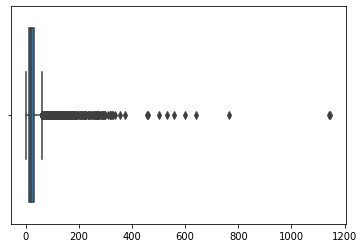

In [64]:
sns.boxplot(lengths)
plt.show()

In [65]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [66]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   30  668   12
   43 1333 1543 1585    3 1607   11  171  526 1740    4   88    3   13
   33    1  140    1  179   39   30   30 1740   92  413  640   11 4360
  243    2] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1  3  3 10
  2  8  3  1  5  2  2  1  5  1  3  9  9  6  9  6  9  3  3  3  1 17  2  8
  5  1  4  3]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [67]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word embeddings
Currently, each word and each tag is encoded as an integer.

We'll use a more sophisticated technique to represent the input words (X) using what's known as word embeddings.

However, to represent each tag in Y, we'll simply use one-hot encoding scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:

1. word2vec model: https://code.google.com/archive/p/word2vec/
2. GloVe model : https://nlp.stanford.edu/projects/glove/

We're using the word2vec model for no particular reason. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

## Use word embeddings for input sequences (X)

In [80]:
# word2vec

path = '/content/word2vec.model-cbow-size=200-window=5.bin'


# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [87]:
# word2vec effectiveness
word2vec.most_similar(positive = ["شاه", "زن"], negative = ["مرد"])

[('احمدشاه', 0.5828825235366821),
 ('پادشاه', 0.5697827339172363),
 ('محمدشاه', 0.5616036653518677),
 ('ناصرالدین\u200cشاه', 0.5586493015289307),
 ('ولیعهد', 0.5397764444351196),
 ('فتحعلی\u200cشاه', 0.5261922478675842),
 ('شاه\u200cعباس', 0.5197480320930481),
 ('گوکبوری', 0.5167436003684998),
 ('دربار', 0.5143003463745117),
 ('رضاشاه', 0.5133230686187744)]

In [89]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 200  # each word in word2vec model is represented using a 200 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [90]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (58316, 200)


In [91]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['کتاب']]

array([ 2.27324462e+00,  6.19029880e-01, -1.89760199e-03, -1.62530839e-01,
       -3.40133309e-01,  7.15490803e-03,  4.38465714e-01, -5.92125878e-02,
       -9.68807340e-01, -1.38433576e+00, -3.04762578e+00,  2.95990467e-01,
        1.07385790e+00, -1.15435159e+00, -5.31624436e-01, -2.56763846e-01,
        1.29102254e+00, -2.81041771e-01,  1.29225636e+00, -8.90765548e-01,
       -1.99803841e+00,  1.14900935e+00, -2.53689557e-01,  3.02091409e-02,
       -2.15287280e+00, -1.12354589e+00,  3.31524515e+00, -1.05865049e+00,
        2.65959835e+00,  3.50926667e-01, -1.17137015e+00, -9.45076823e-01,
        5.91018684e-02,  3.41299987e+00, -1.32753825e+00, -1.15575337e+00,
       -1.99846387e+00, -2.20947957e+00,  9.55326781e-02, -1.91129196e+00,
       -6.60164595e-01,  1.47260499e+00, -3.27217221e+00, -3.76167226e+00,
        8.92697334e-01, -9.27080929e-01,  1.62479258e+00, -6.52753651e-01,
        1.76814890e+00, -2.29427290e+00, -1.17490709e+00, -4.73752052e-01,
       -2.28890419e-01,  

## Use one-hot encoding for output sequences (Y)

In [92]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [93]:
# print Y of the first output sequqnce
print(Y.shape)

(70103, 100, 40)


# Split data in training, validation and tesing sets

In [94]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [95]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [96]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (50648, 100)
Shape of output sequences: (50648, 100, 40)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (8939, 100)
Shape of output sequences: (8939, 100, 40)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10516, 100)
Shape of output sequences: (10516, 100, 40)


# Bidirectional LSTM

## Create model architecture

In [98]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [99]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [100]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [101]:
# check summary of model
bidirect_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          11663200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          135680    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 40)           5160      
Total params: 11,804,040
Trainable params: 11,804,040
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [102]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
396/396 [==============================] - 278s 645ms/step - loss: 0.7337 - acc: 0.8968 - val_loss: 0.0607 - val_acc: 0.9825
Epoch 2/10
396/396 [==============================] - 255s 644ms/step - loss: 0.0487 - acc: 0.9859 - val_loss: 0.0327 - val_acc: 0.9900
Epoch 3/10
396/396 [==============================] - 255s 645ms/step - loss: 0.0264 - acc: 0.9918 - val_loss: 0.0257 - val_acc: 0.9918
Epoch 4/10
396/396 [==============================] - 258s 650ms/step - loss: 0.0186 - acc: 0.9942 - val_loss: 0.0228 - val_acc: 0.9927
Epoch 5/10
396/396 [==============================] - 255s 645ms/step - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0216 - val_acc: 0.9930
Epoch 6/10
396/396 [==============================] - 255s 643ms/step - loss: 0.0124 - acc: 0.9961 - val_loss: 0.0210 - val_acc: 0.9933
Epoch 7/10
396/396 [==============================] - 255s 644ms/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0210 - val_acc: 0.9934
Epoch 8/10
396/396 [============================

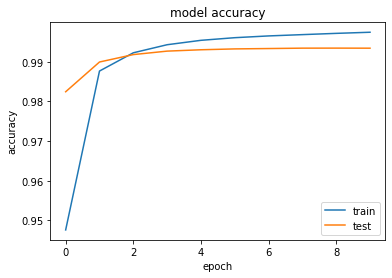

In [103]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

# Model evaluation

In [104]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

329/329 [==============================] - 14s 41ms/step - loss: 0.0226 - acc: 0.9935
Loss: 0.022619688883423805,
Accuracy: 0.9934841990470886
